case分析：对比kimi_pa_v1.1 和 multi_pa_model_v14_7_2 在 tak-k12音素评测测试集上的推理差异

In [64]:
import os
import json
import shutil
import numpy as np
from textgrid import TextGrid, IntervalTier

In [ ]:
def infer_normalize(infer_string:str):
    infer_json = json.loads(infer_string)
    

In [16]:
infer_kimi_res = '/mnt/pfs_l2/jieti_team/SFT/hupeng/github/Kimi-Audio/output/infer_res/Kimi_Pa_V1.1/infer_tal-k12_phoneme_pa_nocot-v1_test.json'
kimi_info_dict = {}
with open(infer_kimi_res, 'r') as f:
    for line in f:
        line = json.loads(line)
        audio = line['audio']
        key, ext = os.path.splitext(os.path.basename(audio))
        pred_json = json.loads(line['predict'])
        true_json = json.loads(line['label'])
        assert len(pred_json) == len(true_json)
        pred_phn_scores, true_phn_scores = [], []
        for pred_item, true_item in zip(pred_json, true_json):
            assert pred_item['word'] == true_item['word']
            assert pred_item['phoneme'] == true_item['phoneme']

            pred_phn_score = list(map(float, pred_item['score'].split()))
            true_phn_score = list(map(float, true_item['score'].split()))
            pred_phn_scores.extend(pred_phn_score)
            true_phn_scores.extend(true_phn_score)
        
        acc = sum([1 if p==t else 0 for p, t in zip(pred_phn_scores, true_phn_scores)]) / len(true_phn_scores)
        kimi_info_dict[key] = {
            'predict': pred_json,
            'acc': acc
        }

In [58]:
infer_mpa_res = '/mnt/pfs_l2/jieti_team/SFT/hupeng/mdd_lm/saves/post_training/base_model_v5/multi_pa_v14_7/infers/model2_all_pa/phoneme-pa_tal-k12_gp.json'
mpa_info_dict = {}
true_info_dict = {}
acc_diff_keys = list()
audio_path_map = {}

with open(infer_mpa_res, 'r') as f:
    for line in f:
        line = json.loads(line)
        audio = line['audio'][0]
        key, ext = os.path.splitext(os.path.basename(audio))
        pred_json = json.loads(line['predict'])
        true_json = json.loads(line['label'])

        true_info_dict[key] = true_json
        audio_path_map[key] = audio

        assert len(pred_json) == len(true_json)
        pred_phn_scores, true_phn_scores = [], []
        for pred_item, true_item in zip(pred_json, true_json):
            assert pred_item['word'] == true_item['word']
            assert pred_item['phoneme'] == true_item['phoneme']

            pred_phn_score = list(map(float, pred_item['score'].split()))
            true_phn_score = list(map(float, true_item['score'].split()))
            pred_phn_scores.extend(pred_phn_score)
            true_phn_scores.extend(true_phn_score)
        
        acc = sum([1 if p==t else 0 for p, t in zip(pred_phn_scores, true_phn_scores)]) / len(true_phn_scores)
        mpa_info_dict[key] = {
            'predict': pred_json,
            'acc': acc
        }

        kimi_acc = kimi_info_dict[key]['acc']
        acc_diff = abs(acc - kimi_acc)
        acc_diff_keys.append((key, acc_diff))
acc_diff_keys = sorted(acc_diff_keys, key=lambda x: x[1], reverse=True)

In [40]:

def ms_to_s(ms):
    return ms / 1000.0

def create_textgrid(data: dict, output_path: str):
    """
    创建 4 层 interval 的 TextGrid 文件
    Args:
        data (dict): 包含 word / phoneme / phoneme_score / phoneme_true_score
                     每个键的值是一个列表：[{"text": str, "start": float, "end": float}, ...]
                     时间单位为毫秒 (ms)
        output_path (str): 输出路径 (.TextGrid)
    """
    tg = TextGrid()

    # 依次创建 4 个层
    for tier_name in ["word", "phoneme", "phoneme_score", "phoneme_true_score"]:
        if tier_name not in data:
            print(f"⚠️ Warning: {tier_name} not in data, skip.")
            continue

        tier_data = data[tier_name]
        tier = IntervalTier(name=tier_name)

        for item in tier_data:
            start_s = item["start"]
            end_s = item["end"]
            text = str(item["text"])
            tier.add(start_s, end_s, text)

        tg.append(tier)

    tg.write(output_path)
    print(f"✅ TextGrid saved to {output_path}")

In [81]:
phoneme_score_pred_all, phoneme_score_true_all = [], []
count, right_count = 0, 0
threashold = 120
for key, _ in acc_diff_keys[0:20]:
    kimi_pred = kimi_info_dict[key]['predict']
    true_pred = true_info_dict[key]

    assert len(kimi_pred) == len(true_pred)

    data = {
        "word": [],
        "phoneme": [],
        "phoneme_score": [],
        "phoneme_true_score": []
    }

    for kimi_item, true_item in zip(kimi_pred, true_pred):
        word = kimi_item['word']
        phoneme = kimi_item['phoneme']
        phoneme_score = kimi_item['score']
        phoneme_true_score = true_item['score']

        phoneme_score_pred_all.extend(list(map(float, phoneme_score.split())))
        phoneme_score_true_all.extend(list(map(float, phoneme_true_score.split())))
        
        start_time = ms_to_s(kimi_item['start'])
        end_time = ms_to_s(kimi_item['end'])

        count += 1
        if true_item['start'] - threashold <= kimi_item['start'] and true_item['end'] + threashold >= kimi_item['end']:
            right_count += 1

        data["word"].append({
            "text": word,
            "start": start_time,
            "end": end_time
        })
        data["phoneme"].append({
            "text": phoneme,
            "start": start_time,
            "end": end_time
        })
        data["phoneme_score"].append({
            "text": str(phoneme_score),
            "start": start_time,
            "end": end_time
        })
        data["phoneme_true_score"].append({
            "text": str(phoneme_true_score),
            "start": start_time,
            "end": end_time
        })

    # output_dir = '/mnt/pfs_l2/jieti_team/SFT/hupeng/github/Kimi-Audio/output/talk12-phn-infer-compare/kimi-pa-v1.1'
    # os.makedirs(output_dir, exist_ok=True)
    # output_path = os.path.join(output_dir, f"{key}_kimi.TextGrid")
    # create_textgrid(data, output_path)
kimi_acc = sum([1 if p==t else 0 for p, t in zip(phoneme_score_pred_all, phoneme_score_true_all)]) / len(phoneme_score_true_all)
kimi_pcc = np.corrcoef(phoneme_score_pred_all, phoneme_score_true_all)[0, 1]
kimi_align_acc = right_count / count
print(f"Kimi Align Acc (threashold={threashold}ms): {kimi_align_acc:.4f}")
print(f"Kimi Acc: {kimi_acc:.4f}")
print(f"Kimi PCC: {kimi_pcc:.4f}")

Kimi Align Acc (threashold=120ms): 0.8393
Kimi Acc: 0.8493
Kimi PCC: 0.6823


In [82]:
phoneme_score_pred_all, phoneme_score_true_all = [], []
count, right_count = 0, 0
threashold = 120
for key, _ in acc_diff_keys[0:20]:
    mpa_pred = mpa_info_dict[key]['predict']
    true_pred = true_info_dict[key]

    assert len(mpa_pred) == len(true_pred)

    data = {
        "word": [],
        "phoneme": [],
        "phoneme_score": [],
        "phoneme_true_score": []
    }

    for mpa_item, true_item in zip(mpa_pred, true_pred):
        word = mpa_item['word']
        phoneme = mpa_item['phoneme']
        phoneme_score = mpa_item['score']
        phoneme_true_score = true_item['score']
        phoneme_score_pred_all.extend(list(map(float, phoneme_score.split())))
        phoneme_score_true_all.extend(list(map(float, phoneme_true_score.split())))
        start_time = ms_to_s(mpa_item['start'])
        end_time = ms_to_s(mpa_item['end'])

        count += 1
        if true_item['start'] - threashold <= mpa_item['start'] and true_item['end'] + threashold >= mpa_item['end']:
            right_count += 1

        data["word"].append({
            "text": word,
            "start": start_time,
            "end": end_time
        })
        data["phoneme"].append({
            "text": phoneme,
            "start": start_time,
            "end": end_time
        })
        data["phoneme_score"].append({
            "text": str(phoneme_score),
            "start": start_time,
            "end": end_time
        })
        data["phoneme_true_score"].append({
            "text": str(phoneme_true_score),
            "start": start_time,
            "end": end_time
        })
    
    # output_dir = '/mnt/pfs_l2/jieti_team/SFT/hupeng/github/Kimi-Audio/output/talk12-phn-infer-compare/mpa-v14.7'
    # os.makedirs(output_dir, exist_ok=True)
    # output_path = os.path.join(output_dir, f"{key}_mpa.TextGrid")
    # create_textgrid(data, output_path)
mpa_acc = sum([1 if p==t else 0 for p, t in zip(phoneme_score_pred_all, phoneme_score_true_all)]) / len(phoneme_score_true_all)
mpa_pcc = np.corrcoef(phoneme_score_pred_all, phoneme_score_true_all)[0, 1]
mpa_align_acc = right_count / count
print(f"MPA Align Acc (threashold={threashold}ms): {mpa_align_acc:.4f}")
print(f"MPA Acc: {mpa_acc:.4f}")
print(f"MPA PCC: {mpa_pcc:.4f}")

MPA Align Acc (threashold=120ms): 0.7679
MPA Acc: 0.7466
MPA PCC: 0.4451


In [60]:
for key, _ in acc_diff_keys[0:20]:
    audio = audio_path_map[key]
    dst_path = os.path.join('/mnt/pfs_l2/jieti_team/SFT/hupeng/github/Kimi-Audio/output/talk12-phn-infer-compare/wavs', f"{key}.wav")
    shutil.copy(audio, dst_path)

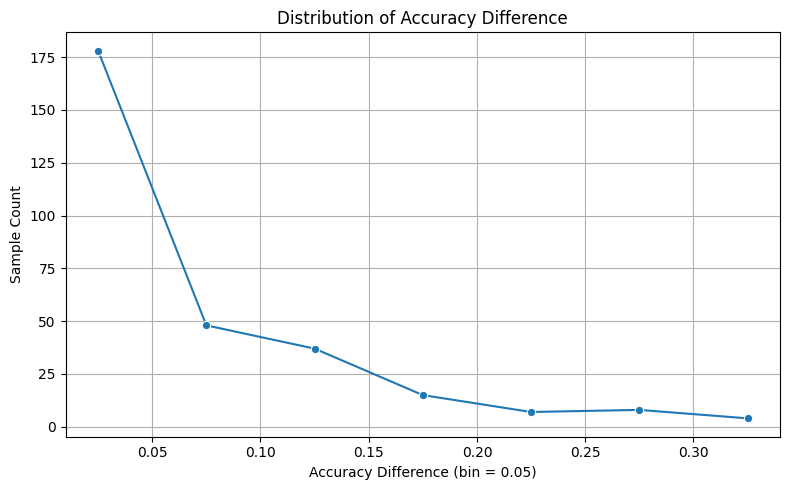

In [86]:
import matplotlib.pyplot as plt
import numpy as np
from seaborn import lineplot

# 原始数据
points = [item[1] for item in acc_diff_keys]

# 定义区间宽度
bin_width = 0.05

# 计算最小值和最大值
min_val = np.floor(min(points) / bin_width) * bin_width
max_val = np.ceil(max(points) / bin_width) * bin_width

# 构建区间边界
bins = np.arange(min_val, max_val + bin_width, bin_width)

# 统计每个区间内的样本数
counts, edges = np.histogram(points, bins=bins)

# 计算每个区间的中心点用于画折线
bin_centers = (edges[:-1] + edges[1:]) / 2

# 画折线图
plt.figure(figsize=(8, 5))
lineplot(x=bin_centers, y=counts, marker="o")
plt.xlabel("Accuracy Difference (bin = 0.05)")
plt.ylabel("Sample Count")
plt.title("Distribution of Accuracy Difference")
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:
import librosa
import numpy as np
import torch
import json
from tqdm import tqdm
import torchaudio

In [3]:
wav = librosa.load('/mnt/pfs_l2/jieti_team/SFT/hupeng/data/tal-k12/wavs/wav_batch5/17031578393741187475575272439808.wav', sr=16000)[0]
# wav = librosa.load('/mnt/pfs_l2/jieti_team/SFT/hupeng/data/en/next_online/online_20250408/wavs/wav_0003/17440532846221359003504858021888.wav', sr=16000)[0]

In [2]:
file = '/mnt/pfs_l2/jieti_team/SFT/hupeng/llm_data/kimi_style/sft/train/train_semantic_codes.json'
def audio_load(file_path):
    try:
        waveform, sample_rate = torchaudio.load(file_path)
        duration = waveform.shape[1] / sample_rate
        if sample_rate == 16000 and duration > 0 and duration <= 25:
            return True
        else:
            return False
    except Exception as e:
        return False

with open(file, 'r') as f:
    for line in f:
        line = json.loads(line)
        audio = line['conversation'][1]['content']
        is_16k = audio_load(audio)
        if not is_16k:
            print(audio)

/mnt/pfs_l2/jieti_team/SFT/hupeng/data/multiple_choice/bdy_wx_0506/wavs/17491253569221380277317994053632.wav
/mnt/pfs_l2/jieti_team/SFT/hupeng/data/multiple_choice/bdy_wx_0506/wavs/17506591112791386710350029185024.wav
/mnt/pfs_l2/jieti_team/SFT/hupeng/data/multiple_choice/bdy_wx_0506/wavs/17489503040661379543093100417025.wav
/mnt/pfs_l2/jieti_team/SFT/hupeng/data/multiple_choice/bdy_wx_0506/wavs/17466150967711369748523801985024.wav
/mnt/pfs_l2/jieti_team/SFT/hupeng/data/multiple_choice/bdy_wx_0506/wavs/17507543447041387109787964198912.wav
/mnt/pfs_l2/jieti_team/SFT/hupeng/data/multiple_choice/bdy_wx_0506/wavs/17491242833571380272815136063488.wav
/mnt/pfs_l2/jieti_team/SFT/hupeng/data/multiple_choice/bdy_wx_0506/wavs/17469627109091371206523171323904.wav
/mnt/pfs_l2/jieti_team/SFT/hupeng/data/multiple_choice/bdy_wx_0506/wavs/17491816250751380513323733618688.wav
/mnt/pfs_l2/jieti_team/SFT/hupeng/data/multiple_choice/bdy_wx_0506/wavs/17473085097051372656908445061120.wav
/mnt/pfs_l2/jieti_t

In [ ]:
data = '/mnt/pfs_l2/jieti_team/SFT/hupeng/llm_data/kimi_style/sft/train/train_semantic_codes.json'
with open(data, 'r') as f:
    lines = f.readlines()
    for line in (lines):
        line = json.loads(line)
        audio_path = line['conversation'][1]['content']
        audio = librosa.load(audio_path, sr=16000)[0]

NameError: name 'librosa' is not defined

In [2]:
file = '/mnt/pfs_l2/jieti_team/SFT/hupeng/data/tal-k12/train/label_sent_score'
max_len = 0
with open(file, 'r') as f:
    for line in f:
        line = line.strip().split('\t')
        sent = line[1]
        word_list = sent.split()
        max_len = max(max_len, len(word_list))
max_len

11

In [24]:
import json
import librosa
import torchaudio
def load_data(data):
    data_set = set()
    with open(data, 'r') as f:
        lines = f.readlines()
        for line in (lines):
            line = json.loads(line)
            audio_path = line['conversation'][1]['content']
            data_set.add(audio_path)
    return data_set
bad_data = '/mnt/pfs_l2/jieti_team/SFT/hupeng/llm_data/kimi_style/sft/train/train.json'
good_data= '/mnt/pfs_l2/jieti_team/SFT/hupeng/llm_data/kimi_style/sft/train/train_25.json'

# bad_data = '/mnt/pfs_l2/jieti_team/SFT/hupeng/llm_data/kimi_style/sft/dev/eval.json'
# good_data= '/mnt/pfs_l2/jieti_team/SFT/hupeng/llm_data/kimi_style/sft/dev/eval_25.json'

bad_set = load_data(bad_data)
good_set = load_data(good_data)
diff_set = bad_set - good_set

In [25]:
for data in diff_set:
    waveform, sample_rate = torchaudio.load(data)
    if sample_rate != 16000:
        print(f"Sample rate not 16k: {data}, {sample_rate}")
    duration = waveform.shape[1] / sample_rate
    if duration >= 30.0 or duration <= 0:
        print(f"Duration > 25s: {data}, {duration}")